# Data Cleaning
The following steps are taken to clean the data:
1. Handing Missing Values (Grouping time series data, then imputation)
2. Trimming noisy data (first, and last 5 seconds)
3. Removal of columns with too many missing values
4. Smoothing data (Kalman filter)
5. Outlier Detection and Removel (Z-score, IQR)

In [161]:
# Handle imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

# Import data from file
input_data = pd.read_csv('../data/all_data.csv')

def print_reliablity(data):
    """
    Prints out the reliability of the data
    """
    UNIQUE_TRANSPORT_MODES = data['transportation_mode'].unique()
    UNIQUE_EXPIREMENT_TYPES = len(data['expirement_id'].unique())

    print("Unique transport modes: ", UNIQUE_TRANSPORT_MODES)
    print("Unique expirement types: ", UNIQUE_EXPIREMENT_TYPES)

def print_stats(stats_df, show_columns=False):
    """
    Prints out some basic statistics about the data
    to keep track of the data quality
    """
    NULL_VALUES = stats_df.isnull().sum()
    TOTAL_VALUES = stats_df.count()
    TOTAL_ROWS = stats_df.shape[0]
    TOTAL_COLUMNS = stats_df.shape[1]
    TOTAL_NULL_VALUES = NULL_VALUES.sum()

    print("Total rows: ", TOTAL_ROWS)
    print("Total columns: ", TOTAL_COLUMNS)
    if show_columns:
        print("Columns:", stats_df.columns)
    print("Total null values: ", TOTAL_NULL_VALUES)
    print("Total values: ", TOTAL_VALUES.sum())

def print_expirement_stats(data):
    total_rows = data.shape[0]
    total_nan_lat = data['Latitude (°)'].isnull().sum()
    total_nan_lon = data['Longitude (°)'].isnull().sum()
    print("Total rows: ", total_rows)
    print("Total NaN values for Latitude: ", total_nan_lat, "Percentage: ", (total_nan_lat / total_rows) * 100, "%")
    print("Total NaN values for Longitude: ", total_nan_lon, "Percentage: ", (total_nan_lon / total_rows) * 100, "%")
    """
    Prints out some basic statistics about a specific expirement
    """
    # for exp_id in data['expirement_id'].unique():
        # print("Expirement ID:", exp_id)
        # print("\tAmount of rows:", len(data[data['expirement_id'] == exp_id]))
        # print("\tNaN values for Latitude:", data[data['expirement_id'] == exp_id]['Latitude (°)'].isnull().sum())
        # print("\tNaN values for Longitude:", data[data['expirement_id'] == exp_id]['Longitude (°)'].isnull().sum())

print_expirement_stats(input_data)
print_reliablity(input_data)
print_stats(input_data)

Total rows:  385400
Total NaN values for Latitude:  378152 Percentage:  98.11935651271406 %
Total NaN values for Longitude:  378152 Percentage:  98.11935651271406 %
Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18
Total rows:  385400
Total columns:  32
Total null values:  9391271
Total values:  2941529


### Handling Missing Values

In [154]:
# For each expirement (from "expirement_id" column), merge the data into 250ms bins (from "Time (s)" column)
# and save the new data into a new dataframe
from datetime import datetime

data_resampled = pd.DataFrame()

# from timestamp and start_date columns, create a new column called time

input_data['time'] = pd.to_timedelta(input_data["Time (s)"], unit='s') + pd.to_datetime(input_data["start_date"], format="%Y-%m-%d %H:%M:%S.%f UTC%z") 

for exp_id in input_data['expirement_id'].unique():
    data_exp = input_data[input_data['expirement_id'] == exp_id]

    # resample the data to 250ms bins
    data_exp = data_exp.set_index('time')
    data_exp = data_exp.resample('250ms').mean(numeric_only=True)

    # update "Time (s)" column to round to 250ms, it should
    # be a float value
    ROUND_TO_NEAREST = 0.25
    data_exp['Time (s)'] = round(data_exp['Time (s)'] / ROUND_TO_NEAREST) * ROUND_TO_NEAREST

    # retrieve the non-numeric columns
    data_exp["start_date"] = input_data[input_data['expirement_id'] == exp_id]["start_date"].mode()[0]
    data_exp["transportation_mode"] = input_data[input_data['expirement_id'] == exp_id]["transportation_mode"].mode()[0]
    data_exp["expirement_id"] = data_exp["expirement_id"].mode()[0]

    data_exp = data_exp.reset_index()
    data_resampled = pd.concat([data_resampled, data_exp])


# Show before and after time series
# plt.figure()
# plt.plot(data[data['expirement_id'] == exp_id]['time'], data[data['expirement_id'] == exp_id]['Gyroscope x (rad/s)'])
# plt.plot(data_exp['time'], data_exp['Gyroscope x (rad/s)'])
# plt.show()

print_reliablity(data_resampled)
print_stats(data_resampled)
print_expirement_stats(data_resampled)



Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18
Total rows:  35021
Total columns:  32
Total null values:  508705
Total values:  611967
Expirement ID: 250870.0
	Amount of rows: 274
	NaN values for Latitude: 207
	NaN values for Longitude: 207
Expirement ID: 889652.0
	Amount of rows: 4153
	NaN values for Latitude: 3113
	NaN values for Longitude: 3113
Expirement ID: 730896.0
	Amount of rows: 1088
	NaN values for Latitude: 825
	NaN values for Longitude: 825
Expirement ID: 349673.0
	Amount of rows: 3643
	NaN values for Latitude: 2792
	NaN values for Longitude: 2792
Expirement ID: 533394.0
	Amount of rows: 1492
	NaN values for Latitude: 1307
	NaN values for Longitude: 1307
Expirement ID: 785409.0
	Amount of rows: 1089
	NaN values for Latitude: 830
	NaN values for Longitude: 830
Expirement ID: 982713.0
	Amount of rows: 747
	NaN values for Latitude: 562
	NaN values for Longitude: 562
Expirement ID: 363558.0
	Amount of rows: 4775
	NaN values for Latitude: 4715

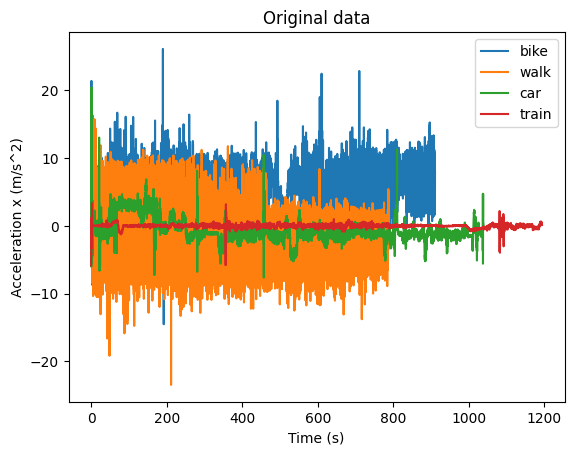

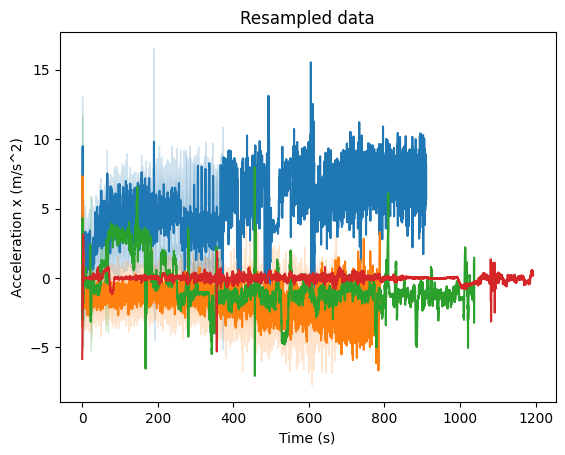

Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18
Total rows:  34554
Total columns:  32
Columns: Index(['time', 'Time (s)', 'Latitude (°)', 'Longitude (°)', 'Height (m)',
       'Velocity (m/s)', 'Direction (°)', 'Horizontal Accuracy (m)',
       'Vertical Accuracy (°)', 'X (µT)', 'Y (µT)', 'Z (µT)', 'Distance (cm)',
       'expirement_id', 'Acceleration x (m/s^2)', 'Acceleration y (m/s^2)',
       'Acceleration z (m/s^2)', 'Gyroscope x (rad/s)', 'Gyroscope y (rad/s)',
       'Gyroscope z (rad/s)', 'Illuminance (lx)',
       'Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)',
       'Linear Acceleration z (m/s^2)', 'Vertical Accuracy (m)',
       'Magnetic field x (µT)', 'Magnetic field y (µT)',
       'Magnetic field z (µT)', 'Pressure (hPa)', 'Temperature (°C)',
       'start_date', 'transportation_mode'],
      dtype='object')
Total null values:  500389
Total values:  605339


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


# Print duplicates based on subset columns, and remove them
duplicates = data_resampled[data_resampled.duplicated(subset=['Time (s)', 'expirement_id'])]
data_resampled = data_resampled.drop_duplicates(subset=['Time (s)', 'expirement_id'])

# Ensure no duplicate indices
data_resampled = data_resampled.reset_index(drop=True)

# Gyroscope data -> resampled data vs original data

plt.figure()
sns.lineplot(data=input_data[input_data['transportation_mode'] == 'bike'], x='Time (s)', y='Acceleration x (m/s^2)', label='bike')
sns.lineplot(data=input_data[input_data['transportation_mode'] == 'walk'], x='Time (s)', y='Acceleration x (m/s^2)', label='walk')
sns.lineplot(data=input_data[input_data['transportation_mode'] == 'car'], x='Time (s)', y='Acceleration x (m/s^2)', label='car')
sns.lineplot(data=input_data[input_data['transportation_mode'] == 'train'], x='Time (s)', y='Acceleration x (m/s^2)', label='train')
plt.title('Original data')
plt.show()

plt.figure()
sns.lineplot(data=data_resampled[data_resampled['transportation_mode'] == 'bike'], x='Time (s)', y='Acceleration x (m/s^2)')
sns.lineplot(data=data_resampled[data_resampled['transportation_mode'] == 'walk'], x='Time (s)', y='Acceleration x (m/s^2)')
sns.lineplot(data=data_resampled[data_resampled['transportation_mode'] == 'car'], x='Time (s)', y='Acceleration x (m/s^2)')
sns.lineplot(data=data_resampled[data_resampled['transportation_mode'] == 'train'], x='Time (s)', y='Acceleration x (m/s^2)')
plt.title('Resampled data')
plt.show()

# Verify consistency of data
print_reliablity(data_resampled)
print_stats(data_resampled)

# Save the resampled data to a new file
data_resampled.to_csv('../data/all_data_resampled.csv', index=False)


#### ^ We can clearly see how noise is removed from the data when we take larger time intervals to group the data. This is because the noise is random and the mean of the data is more likely to be the true value than the individual data points.

## Outlier Detection and Removal

In [20]:
# # We want to compare z-score and IQR to see which one is better at removing outliers.
# # better meaning that it removes the most noise while keeping the most data points.
# import numpy as np
# import pandas as pd
# from scipy import stats

# data_resampled = pd.read_csv('../data/all_data_resampled.csv')

# # Statistics to measure against outlier removals
# TOTAL_ROWS = data_resampled.shape[0]
# TOTAL_COLUMNS = data_resampled.shape[1]

# data_resampled.describe()

# # Print out some basic statistics about the data
# print("Before outlier removal")
# print("Total rows: ", TOTAL_ROWS)
# print("Total columns: ", TOTAL_COLUMNS)


# ### Z-Score
# def z_score(data, threshold=3):
#     """
#     Removes outliers using the z-score method,
#     keep non-numeric columns as well,
#     ignore the nan values
#     """
#     data = data.copy()

#     data = data.select_dtypes(include=[np.number])

#     z_scores = stats.zscore(data, nan_policy='omit')
#     abs_z_scores = np.abs(z_scores)
#     filtered_entries = (abs_z_scores < threshold).all(axis=1)

#     data = data[filtered_entries]


#     return data

# data_resampled_z_score = z_score(data_resampled)

# # Verify consistency of data
# print("Z-Score")
# print_stats(data_resampled_z_score)
# print_reliablity(data_resampled_z_score)

# ### IQR
# def iqr(data):
#     """
#     Removes outliers using the IQR method
#     """
#     data = data.copy()
#     data = data.select_dtypes(include=[np.number])

#     Q1 = data.quantile(0.25)
#     Q3 = data.quantile(0.75)
#     IQR = Q3 - Q1

#     data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

#     return data

# data_resampled_iqr = iqr(data_resampled)

# # Verify consistency of data
# print("IQR-score")
# print_stats(data_resampled_iqr)
# print_reliablity(data_resampled_iqr)

# # Place them against each other
# plt.figure()
# sns.lineplot(data=data_resampled, x='Time (s)', y='Acceleration x (m/s^2)', label='original')
# sns.lineplot(data=data_resampled_z_score, x='Time (s)', y='Acceleration x (m/s^2)', label='z-score')
# sns.lineplot(data=data_resampled_iqr, x='Time (s)', y='Acceleration x (m/s^2)', label='iqr')
# plt.title('Z-Score vs IQR')
# plt.show()

## Trimming noisy data


In [142]:
# Remove the first and last 3 seconds of each expirement in the data
def remove_start_end(data, seconds=10):
    """
    Removes the first and last x seconds of the data for each expirement
    """
    data = data.copy()

    for exp_id in data['expirement_id'].unique():
        data_exp = data[data['expirement_id'] == exp_id]
        data_exp = data_exp[data_exp['Time (s)'] > seconds]
        data_exp = data_exp[data_exp['Time (s)'] < data_exp['Time (s)'].max() - seconds]

        data = data[data['expirement_id'] != exp_id]
        data = pd.concat([data, data_exp])

    return data

data_resampled_removed_start_end = remove_start_end(data_resampled)

# Save the resampled data to a new file
data_resampled_removed_start_end.to_csv('../data/all_data_remove_start_end.csv', index=False)

# Verify consistency of data
print("Removed start and end")
print_stats(data_resampled_removed_start_end)
print_reliablity(data_resampled_removed_start_end)

Removed start and end
Total rows:  33539
Total columns:  32
Total null values:  486306
Total values:  586942
Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18


## Removal of columns with too many missing values

In [143]:
def remove_columns_with_80_or_more(data):
    """
    Removes columns where 80% of the data is missing
    """
    data = data.copy()

    for col in data.columns:
        if data[col].isnull().sum() >= 0.8 * data.shape[0]:
            print("\tRemoving column: ", col)
            data = data.drop(col, axis=1)

    return data

data_removed_columns = remove_columns_with_80_or_more(data_resampled_removed_start_end)

print("after: columns with 80% or less missing values")
print_stats(data_removed_columns)
print_reliablity(data_removed_columns)

def remove_not_all_transportation_modes(data):
    """
    Removes columns where not each transportation mode has atleast one value
    """
    data = data.copy()

    for col in data.columns:
        if col in ['Time (s)', 'expirement_id', 'start_date', 'transportation_mode', "time"]:
            continue

        # Check if the column has values for each transportation mode
        unique_transportation_modes = data['transportation_mode'].unique()

        for transportation_mode in unique_transportation_modes:
            if data[data['transportation_mode'] == transportation_mode][col].isnull().all():
                print("\tRemoving column: ", col)
                data = data.drop(col, axis=1)
                break

    return data

data_removed_transportation_modes = remove_not_all_transportation_modes(data_removed_columns)

# Save the resampled data to a new file
data_removed_transportation_modes.to_csv('../data/all_data_column_removal.csv', index=False)

print("after: transportation modes with all values")
print_stats(data_removed_transportation_modes)
print_reliablity(data_removed_transportation_modes)
print(data_removed_transportation_modes.columns)

	Removing column:  Vertical Accuracy (°)
	Removing column:  Distance (cm)
	Removing column:  Vertical Accuracy (m)
after: columns with 80% or less missing values
Total rows:  33539
Total columns:  29
Total null values:  394726
Total values:  577905
Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18
	Removing column:  Height (m)
	Removing column:  Velocity (m/s)
	Removing column:  Direction (°)
	Removing column:  X (µT)
	Removing column:  Y (µT)
	Removing column:  Z (µT)
	Removing column:  Illuminance (lx)
	Removing column:  Linear Acceleration x (m/s^2)
	Removing column:  Linear Acceleration y (m/s^2)
	Removing column:  Linear Acceleration z (m/s^2)
	Removing column:  Magnetic field x (µT)
	Removing column:  Magnetic field y (µT)
	Removing column:  Magnetic field z (µT)
	Removing column:  Pressure (hPa)
	Removing column:  Temperature (°C)
after: transportation modes with all values
Total rows:  33539
Total columns:  14
Total null values:  79758
Total va

## Smoothing Data

In [144]:
# Use a kalman filter class given by the course library
import numpy as np
from pykalman import KalmanFilter

# Implements the Kalman filter for single columns.
class KalmanFilters:

    # Very simple Kalman filter: fill missing values and remove outliers for single attribute.
    # We assume a very simple transition matrix, namely simply a [[1]]. It
    # is however still useful as it is able to dampen outliers and impute missing values. The new
    # values are appended in a new column.
    def apply_kalman_filter(self, data_table, col):
        # Initialize the Kalman filter with the trivial transition and observation matrices.
        kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])

        numpy_array_state = data_table[col].values
        numpy_array_state = numpy_array_state.astype(np.float32)
        numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)

        # Find the best other parameters based on the data (e.g. Q)
        kf = kf.em(numpy_matrix_state_with_mask, n_iter=5)

        # And apply the filter.
        (new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)

        data_table[col + "_kalman"] = new_data
        return data_table

# Apply the Kalman filter to all numeric columns in the data table.
kf = KalmanFilters()

exclude_columns = ['Time (s)', 'expirement_id', 'start_date', 'transportation_mode', "time"]
data_resampled_kalman = data_removed_transportation_modes.copy()
for col in data_resampled_kalman.select_dtypes(include=[np.number]).columns:
    if col in exclude_columns:
        continue
    print("Applying Kalman filter to column: ", col)
    data_resampled_kalman = kf.apply_kalman_filter(data_resampled_kalman, col)

    # Save the resampled data to a new file
    data_resampled_kalman.to_csv('../data/all_data_kalman.csv', index=False)



# Verify consistency of data
print("Kalman filter")
print_stats(data_resampled_kalman)
print_reliablity(data_resampled_kalman)

Applying Kalman filter to column:  Latitude (°)
Applying Kalman filter to column:  Longitude (°)
Applying Kalman filter to column:  Horizontal Accuracy (m)
Applying Kalman filter to column:  Acceleration x (m/s^2)
Applying Kalman filter to column:  Acceleration y (m/s^2)
Applying Kalman filter to column:  Acceleration z (m/s^2)
Applying Kalman filter to column:  Gyroscope x (rad/s)
Applying Kalman filter to column:  Gyroscope y (rad/s)
Applying Kalman filter to column:  Gyroscope z (rad/s)
Kalman filter
Total rows:  33539
Total columns:  23
Total null values:  79758
Total values:  691639
Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18


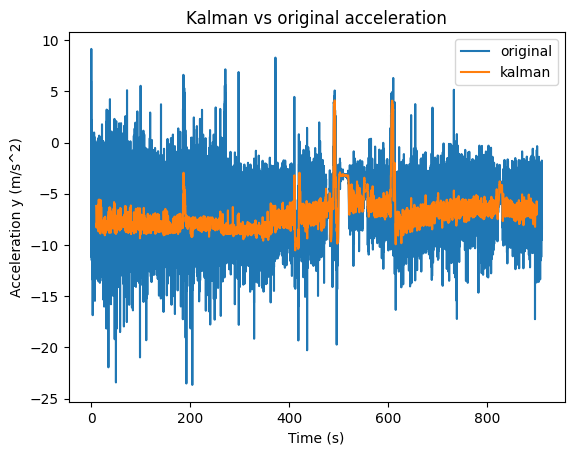

In [145]:
# Show kalman acceleration vs original acceleration
plt.figure()
sns.lineplot(data=input_data[input_data['transportation_mode'] == 'bike'], x='Time (s)', y='Acceleration y (m/s^2)', label='original')
sns.lineplot(data=data_resampled_kalman[data_resampled_kalman['transportation_mode'] == 'bike'], x='Time (s)', y='Acceleration y (m/s^2)_kalman', label='kalman')
plt.title('Kalman vs original acceleration')
plt.show()

## Remove outliers using z-score

In [149]:
# Remove outliers using the z-score method


from scipy import stats


print("Before outlier removal")
print_stats(data_resampled_kalman)
print_reliablity(data_resampled_kalman)
print("\n")

exclude_columns = ['Time (s)', 'expirement_id', 'start_date', 'transportation_mode', "time"]

def z_score_per_expirement(input_data, threshold=2):
    """
    Replaces outliers in numeric columns with NaN using the z-score method,
    per experiment
    """
    input_data = input_data.copy()

    for expirement_id in input_data['expirement_id'].unique():
        data_mode = input_data[input_data['expirement_id'] == expirement_id]

        for col in data_mode.select_dtypes(include=[np.number]).columns:
            if col in exclude_columns:
                continue

            z_scores = stats.zscore(data_mode[col], nan_policy='omit')
            abs_z_scores = np.abs(z_scores)
            filtered_entries = abs_z_scores < threshold

            data_mode.loc[~filtered_entries, col] = np.nan

        input_data.loc[input_data['expirement_id'] == expirement_id] = data_mode

    return input_data


data_resampled_z_score = z_score_per_expirement(data_resampled_kalman)

# Verify consistency of data
print("Z-Score")
print_stats(data_resampled_z_score)
print_reliablity(data_resampled_z_score)

Before outlier removal
Total rows:  33539
Total columns:  23
Total null values:  79758
Total values:  691639
Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18


Z-Score
Total rows:  33539
Total columns:  23
Total null values:  97062
Total values:  674335
Unique transport modes:  ['car' 'bike' 'train' 'walk']
Unique expirement types:  18


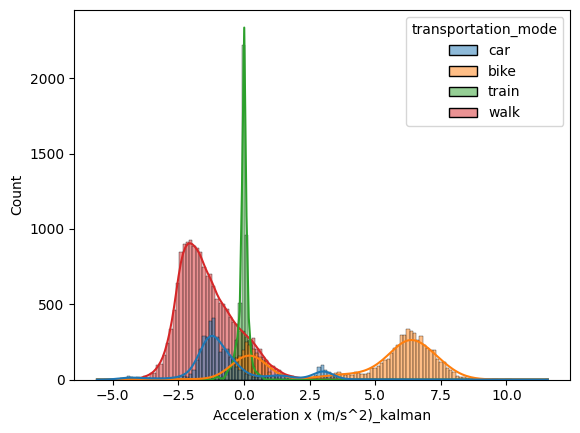

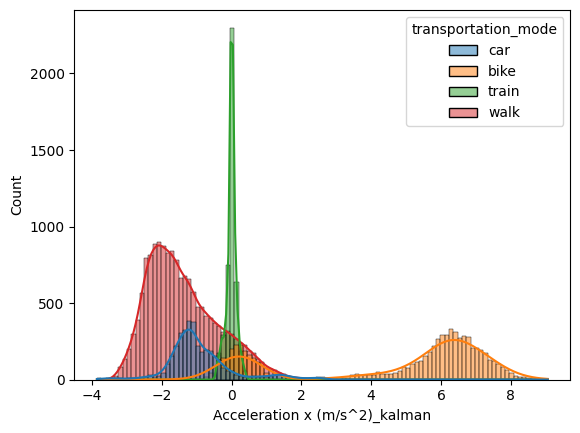

In [150]:
# Show the distributions of acceleration x for each transportation mode
# Make the colors good for color blind people
data_resampled_kalman = data_resampled_kalman.reset_index(drop=True)
data_resampled_z_score = data_resampled_z_score.reset_index(drop=True)

plt.figure()
sns.histplot(data=data_resampled_kalman, x='Acceleration x (m/s^2)_kalman', hue='transportation_mode', kde=True)
plt.show()

plt.figure()
sns.histplot(data=data_resampled_z_score, x='Acceleration x (m/s^2)_kalman', hue='transportation_mode', kde=True)
plt.show()




In [151]:
# Save the cleaned data to a new file
data_resampled_z_score.to_csv('../data/all_data_cleaned.csv', index=False)

<Axes: >

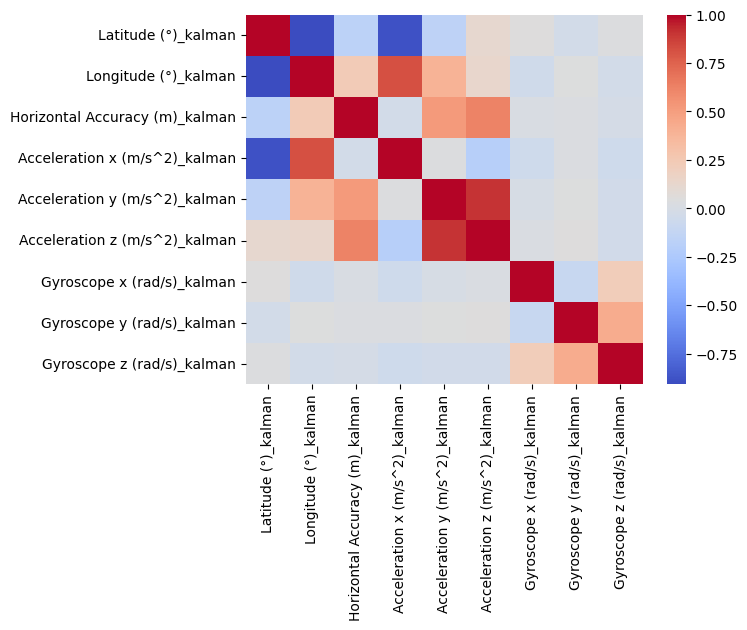

In [152]:
exclude_columns = ['Time (s)', 'expirement_id', 'start_date', 'transportation_mode', "time"]

trimmed_data_resampled_z_score = data_resampled_z_score[[col for col in data_resampled_z_score.columns if col.endswith('_kalman')]]

trimmed_data_resampled_z_score.corr()
import seaborn as sns

sns.heatmap(trimmed_data_resampled_z_score.corr(), cmap='coolwarm')

In [162]:
print("\nResampled ")
print_expirement_stats(data_resampled)

print("\nRemoved start and end")
print_expirement_stats(data_resampled_removed_start_end)

print("\nRemoved columns with 80% or more missing values")
print_expirement_stats(data_removed_transportation_modes)

print("\nKalman filter")
print_expirement_stats(data_resampled_kalman)

print("\nZ-Score")
print_expirement_stats(data_resampled_z_score)


Resampled 
Total rows:  35021
Total NaN values for Latitude:  27791 Percentage:  79.35524399645927 %
Total NaN values for Longitude:  27791 Percentage:  79.35524399645927 %

Removed start and end
Total rows:  33539
Total NaN values for Latitude:  26584 Percentage:  79.2629476132264 %
Total NaN values for Longitude:  26584 Percentage:  79.2629476132264 %

Removed columns with 80% or more missing values
Total rows:  33539
Total NaN values for Latitude:  26584 Percentage:  79.2629476132264 %
Total NaN values for Longitude:  26584 Percentage:  79.2629476132264 %

Kalman filter
Total rows:  33539
Total NaN values for Latitude:  26584 Percentage:  79.2629476132264 %
Total NaN values for Longitude:  26584 Percentage:  79.2629476132264 %

Z-Score
Total rows:  33539
Total NaN values for Latitude:  26709 Percentage:  79.63564805152211 %
Total NaN values for Longitude:  26792 Percentage:  79.88312114255046 %


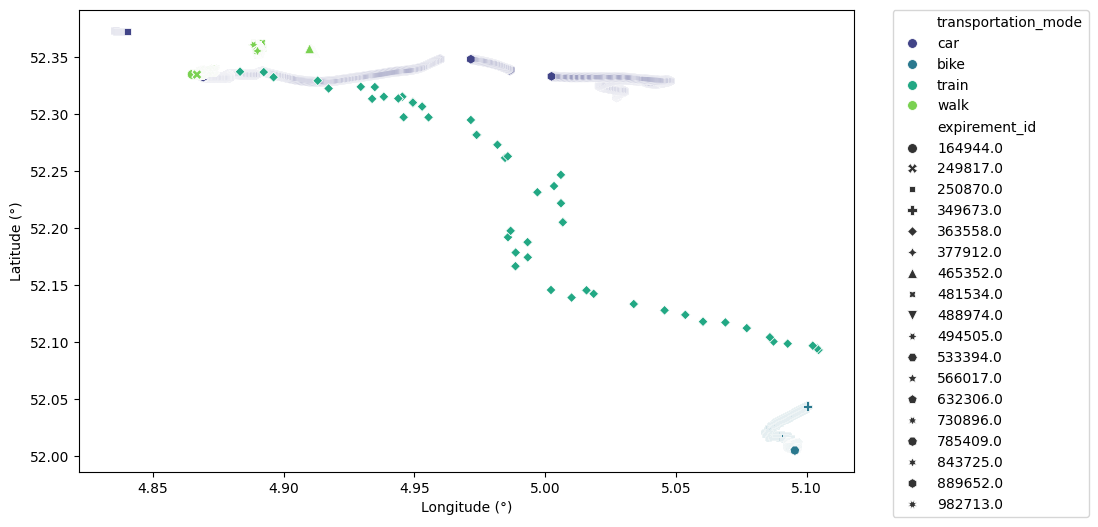

/var/folders/vm/v4f6vcp54rnd_9s9nybhpxj80000gn/T/ipykernel_98416/2803722824.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[col] = dataset[col].interpolate()
/var/folders/vm/v4f6vcp54rnd_9s9nybhpxj80000gn/T/ipykernel_98416/2803722824.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset[col] = dataset[col].fillna(method='bfill')
/var/folders/vm/v4f6vcp54rnd_9s9nybhpxj80000gn/T/ipykernel_98416/2803722824.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [31]:
# Imputing lat/long value
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simple class to impute missing values of a single columns.
class ImputationMissingValues:

    # Impute the mean values in case if missing data.
    def impute_mean(self, dataset, col):
        dataset[col] = dataset[col].fillna(dataset[col].mean())
        return dataset

    # Impute the median values in case if missing data.
    def impute_median(self, dataset, col):
        dataset[col] = dataset[col].fillna(dataset[col].median())
        return dataset

    # Interpolate the dataset based on previous/next values..
    def impute_interpolate(self, dataset, col):
        dataset[col] = dataset[col].interpolate()
        # And fill the initial data points if needed:
        dataset[col] = dataset[col].fillna(method='bfill')
        return dataset

# Read all_data_cleaned.csv
data = pd.read_csv('../data/all_data_cleaned.csv')

# Show longitude and latitude for train 
plt.figure(figsize=(10,6))

# show difference in color per expirement as well
sns.scatterplot(x='Longitude (°)', y='Latitude (°)', hue='transportation_mode', data=data, style="expirement_id", s=50, palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()



# Impute the Latitude (°) and Longitude (°) columns per expirement_id
imputer = ImputationMissingValues()

for expirement_id in data['expirement_id'].unique():
    data_mode = data[data['expirement_id'] == expirement_id]

    data_mode = imputer.impute_interpolate(data_mode, 'Latitude (°)')
    data_mode = imputer.impute_interpolate(data_mode, 'Longitude (°)')

    data.loc[data['expirement_id'] == expirement_id] = data_mode

# Save data to a new file
data.to_csv('../data/all_data_cleaned.csv', index=False)

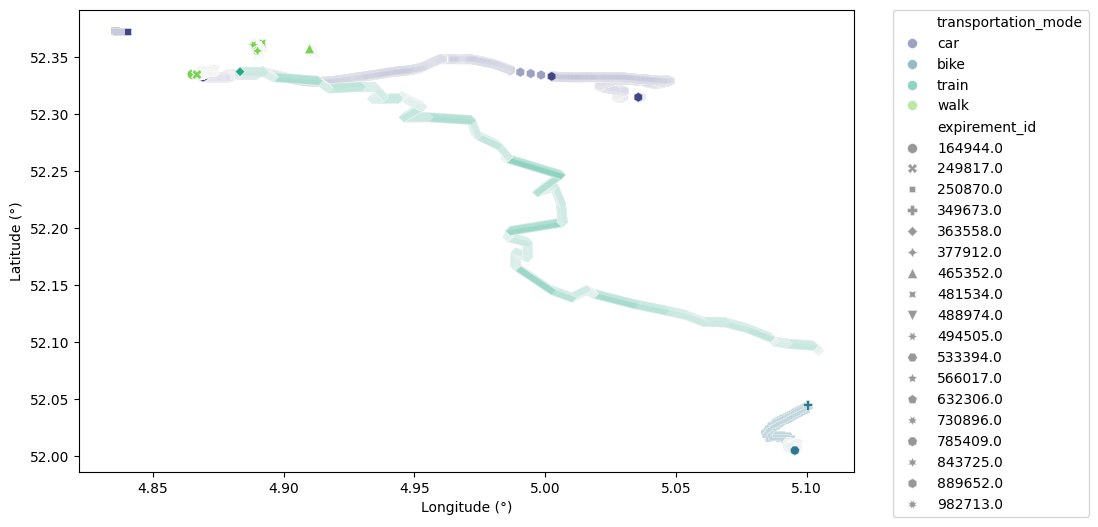

In [28]:
# Show longitude and latitude for train 
plt.figure(figsize=(10,6))

# show difference in color per expirement as well
sns.scatterplot(x='Longitude (°)', y='Latitude (°)', hue='transportation_mode', data=data, style="expirement_id", s=50, palette='viridis', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [29]:
from geopy.distance import geodesic
from math import isnan

LAT_COL = "Latitude (°)"
LONG_COL = "Longitude (°)"

# 60 lamb = 15 seconds
def calculate_delta_x_per_experiment(data, lamb=60):
    """
    Calculate the distance between the current row and the row lamb rows before it,
    for each experiment separately.

    Parameters
    ----------
    data : pd.DataFrame
        The data to calculate the distance for.
    lamb : int
        The number of rows to look back to calculate the distance. Each row is assumed to be
        250ms apart.
    """
    data['delta_x'] = np.nan

    for experiment in data['expirement_id'].unique():
        experiment_data = data[data['expirement_id'] == experiment]
        for i in range(1, len(experiment_data)):
            if i - lamb < 0:
                data.loc[experiment_data.index[i], 'delta_x'] = np.nan
                continue
            lat1 = experiment_data.iloc[i][LAT_COL]
            lon1 = experiment_data.iloc[i][LONG_COL]
            lat2 = experiment_data.iloc[i - lamb][LAT_COL]
            lon2 = experiment_data.iloc[i - lamb][LONG_COL]

            if isnan(lat1) or isnan(lon1) or isnan(lat2) or isnan(lon2):
                data.loc[experiment_data.index[i], 'delta_x'] = np.nan
                continue

            distance = geodesic((lat1, lon1), (lat2, lon2)).m

            # We want to remove outliers from the data
            # max out at 200 km/h ~ 60 m/s ~ 900 meters per 15 seconds
            if distance > 900:
                data.loc[experiment_data.index[i], 'delta_x'] = 900
                continue

            data.loc[experiment_data.index[i], 'delta_x'] = distance

    return data

data = calculate_delta_x_per_experiment(data)


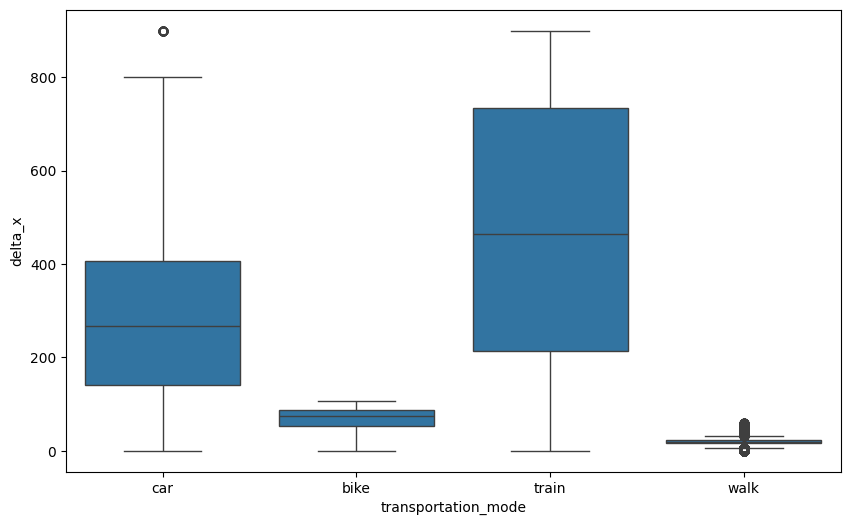

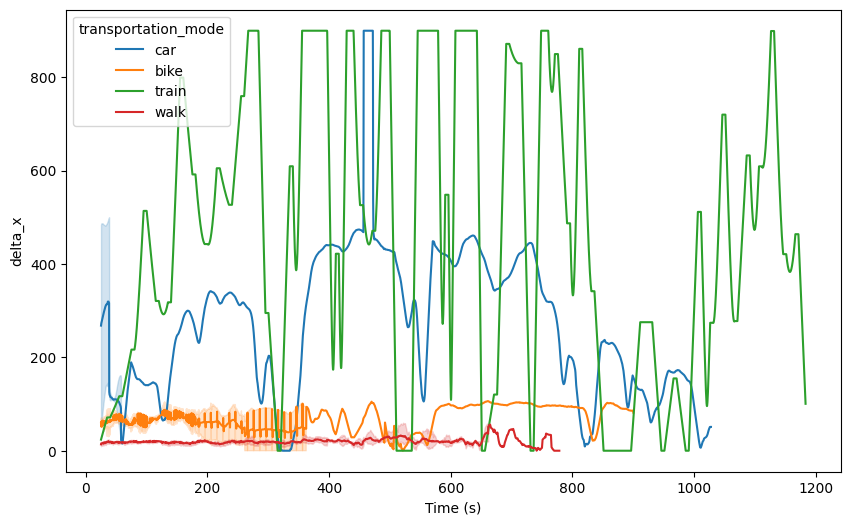

In [30]:

# Show the delta_x per transportation mode
plt.figure(figsize=(10,6))
sns.boxplot(y='delta_x', x='transportation_mode', data=data)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(y='delta_x', x='Time (s)', hue='transportation_mode', data=data)
plt.show()
